# Ionisation potential of a bulk material

In this example we use `MacroDensity` with `VASP` to align the energy levels of a simple bulk material.

The procedure involves two DFT calculations, yielding different important values

* **A bulk calculation**, this provides us with the VBM eigenvalue under the assumption of zero potential ($\epsilon_{vbm}$)
* **A slab calculation**, this provides us with the vacuum level with resepct to the potential inside the material, the difference between these values is the surface dipole ($D_s$).

The ionisation potential ($IP$) is then obtained from:

$IP = D_s - \epsilon_{vbm}$

In [1]:
%matplotlib inline
import macrodensity as md
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Bulk calculation

In this calculation we calculate the eigenvalues of the bulk material, under the assumption of zero average potential.

You find the eigenvalues printed after the line "band No.  band energies     occupation" in the `OUTCAR`

For a spin un-polarised calculation, I have a very simple `bash` script to get the highest occupied value.

    #!/bin/bash
    nkpts=`grep NKPTS OUTCAR | awk '{print $4}'`
    uband=`grep NELECT OUTCAR | awk '{print $3/2+1}'`
    grep "  $uband   " OUTCAR | tail -$nkpts | awk '{print $2}' | sort -n | head
    
Let's try it out on the OUTCAR_bulk file in this directory

In [2]:
%%bash
nkpts=`grep NKPTS OUTCAR_MoO3_bulk | awk '{print $4}'`
uband=`grep NELECT OUTCAR_MoO3_bulk | awk '{print $3/2}'`
grep "  $uband   " OUTCAR_MoO3_bulk | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

1.0742


## Slab calculation

Now we do a calculation of the slab to get the potential profile. Important settings for the `INCAR` file:

    LVHAR = .TRUE.  # This generates a LOCPOT file with the potential 
    
In your example directory there should already be a `LOCPOT_MoO3.vasp` file. This is the one we will use to analyse the potential and extract the vacuum level and the surface dipole.

In the sample `PlanarAverage.py` file, all we have to edit are the top three lines. Of these the only one that is not obvious is the `lattice_vector` parameter. This is just the periodicity of the slab in the direction normal to the surface. In the picture below, this is just the distance between the layers of SnO$_2$.

<img src="MoO3.png">

In [3]:
input_file = 'LOCPOT_MoO3.vasp'
lattice_vector = 7.43
output_file = 'planar.dat'

### The code below is set in the PlanarAverage.py file; you don't need to edit it

In [5]:
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)

Reading potential at point 100000
Reading potential at point 200000
Reading potential at point 300000
Reading potential at point 400000
Reading potential at point 500000
Reading potential at point 600000
Reading potential at point 700000
Reading potential at point 800000
Reading potential at point 900000
Reading potential at point 1000000
Reading potential at point 1100000
Reading potential at point 1200000
Reading potential at point 1300000
Reading potential at point 1400000
Reading potential at point 1500000
Reading potential at point 1600000
Reading potential at point 1700000
Reading potential at point 1800000
Reading potential at point 1900000
Reading potential at point 2000000
Reading potential at point 2100000
Reading potential at point 2200000
Reading potential at point 2300000
Reading potential at point 2400000
Reading potential at point 2500000
Reading potential at point 2600000
Reading potential at point 2700000
Reading potential at point 2800000
Reading potential at point 29

### The code below will prompt you to say which axis you want to average along

In [6]:
## POTENTIAL
planar = md.planar_average(grid_pot,NGX,NGY,NGZ)
## MACROSCOPIC AVERAGE
macro  = md.macroscopic_average(planar,lattice_vector,resolution_z)

Which axis do you wish to plot along?(x,y,z)LOWER CASE!! z
('Average of the average = ', 3.0884924247705688e-14)


### Now we can plot the results

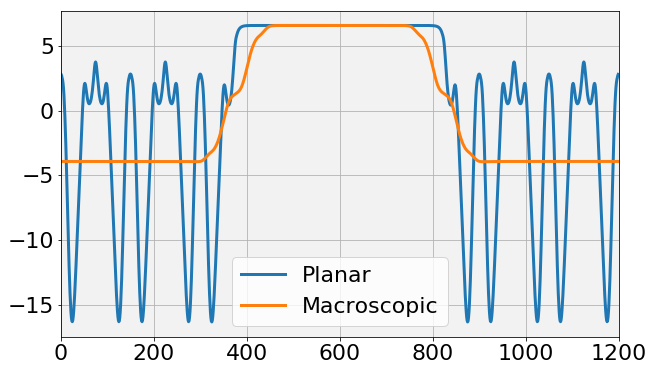

In [8]:
fig, ax1 = plt.subplots(1, 1, sharex=True)

textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize
mpl.rcParams['ytick.labelsize'] = textsize
mpl.rcParams['figure.figsize'] = (10, 6)

ax1.plot(planar,label="Planar",lw=3)
ax1.plot(macro,label="Macroscopic",lw=3)

ax1.set_xlim(0,len(planar))

ax1.set_facecolor((0.95,0.95,0.95))
ax1.grid(True)

ax1.legend(fontsize=22)
plt.show()
np.savetxt(output_file,macro)

### PROTIP

Sometimes the macroscopic average potential in the slab still looks very wavey. In this case it is sometimes required to increase the `lattice_vector` setting from earlier, since there are sometimes numerical effects. 

### Get the surface dipole ($D_s$)

From inspection of the macroscopic average, saved in `planar.dat` we can find that the value of $V$ at each plateau is 6.58 V and -3.93 V. So the step $D_s$ is 10.51 V

### The offset

Applying the equation from earlier, the IP is 

10.51 - 1.07 = 9.44 eV

## Exercise - IP for Bi$_2$O$_3$

Use the procedure above and the Bi$_2$O$_3$ files to calculate the IP.

Some information to assist with the assignment of `lattice_vector`:

   * The $c$ lattice vector of the slab is 45.00 A.
   * There are 840 sub-divisions along $c$. This can be set with the `NGZ` flag.
   * The cell is 6 repeating unit cells long in the $c$-direction.

In [9]:
%%bash
nkpts=`grep NKPTS OUTCAR_Bi2O3_bulk | awk '{print $4}'`
uband=`grep NELECT OUTCAR_Bi2O3_bulk | awk '{print $3/2}'`
grep "  $uband   " OUTCAR_Bi2O3_bulk | tail -$nkpts | awk '{print $2}' | sort -n | head | tail -1

5.5121


In [10]:
input_file = 'LOCPOT_Bi2O3.vasp'
lattice_vector = 7.55
output_file = 'planar.dat'

In [11]:
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)

Reading potential at point 100000
Reading potential at point 200000
Reading potential at point 300000
Reading potential at point 400000
Reading potential at point 500000
Reading potential at point 600000
Reading potential at point 700000
Reading potential at point 800000
Reading potential at point 900000
Reading potential at point 1000000
Reading potential at point 1100000
Reading potential at point 1200000
Reading potential at point 1300000
Reading potential at point 1400000
Reading potential at point 1500000
Reading potential at point 1600000
Reading potential at point 1700000
Reading potential at point 1800000
Reading potential at point 1900000
Reading potential at point 2000000
Reading potential at point 2100000
Reading potential at point 2200000
Reading potential at point 2300000
Reading potential at point 2400000
Reading potential at point 2500000
Reading potential at point 2600000
Reading potential at point 2700000
Reading potential at point 2800000
Reading potential at point 29

In [12]:
## POTENTIAL
planar = md.planar_average(grid_pot,NGX,NGY,NGZ)
## MACROSCOPIC AVERAGE
macro  = md.macroscopic_average(planar,lattice_vector,resolution_z)

Which axis do you wish to plot along?(x,y,z)LOWER CASE!! z
('Average of the average = ', -1.0827317878249145e-14)


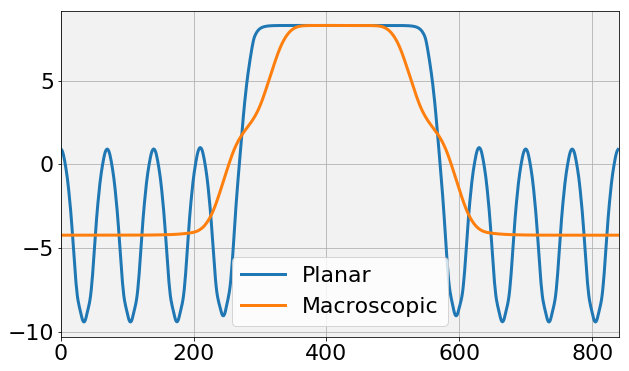

In [13]:
fig, ax1 = plt.subplots(1, 1, sharex=True)

textsize = 22
mpl.rcParams['xtick.labelsize'] = textsize
mpl.rcParams['ytick.labelsize'] = textsize
mpl.rcParams['figure.figsize'] = (10, 6)

ax1.plot(planar,label="Planar",lw=3)
ax1.plot(macro,label="Macroscopic",lw=3)

ax1.set_xlim(0,len(planar))

ax1.set_facecolor((0.95,0.95,0.95))
ax1.grid(True)

ax1.legend(fontsize=22)
plt.show()
np.savetxt(output_file,macro)